In [19]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as mcolors
from scipy.interpolate import LinearNDInterpolator, griddata
#from src.woa23_utils import calculate_sea_density
import gsw  # TEOS-10 GSW-Python library

In [25]:
# Function to calculate sea density
def calculate_sea_density(temp, sal, pressure, lon, lat):
    """
    Calculate potential density anomaly (σθ) using TEOS-10 GSW-Python library.

    Parameters:
    - temp: Conservative Temperature (θ in °C).
    - sal: Practical Salinity (SP).
    - pressure: Pressure (dbar).
    - lon: Longitude (°E).
    - lat: Latitude (°N).

    Returns:
    - Potential density anomaly (σθ in kg/m^3).
    """
    SA = gsw.SA_from_SP(sal, pressure, lon, lat)  # Absolute Salinity (g/kg)
    CT = gsw.CT_from_t(SA, temp, pressure)  # Conservative Temperature (°C)
    sigma_theta = gsw.sigma0(SA, CT)  # Potential Density Anomaly (kg/m^3)
    return sigma_theta

# Function to fetch data from the WOA23 API
def fetch_woa23_data(lon0, lat0, lon1, lat1, dep0, dep1):
    base_url = "https://eco.odb.ntu.edu.tw/api/woa23"
    params = {
        "lon0": lon0,
        "lat0": lat0,
        "lon1": lon1,
        "lat1": lat1,
        "dep0": dep0,
        "dep1": dep1,
        "parameter": "temperature,salinity,oxygen",
        "time_period": 0,
        "append": "an",
        "grid": 1,
    }
    response = requests.get(base_url, params=params)
    return response.json()

# Helper function to process data for contour plots
def process_section_data(data):
    """Process data with improved handling of missing values."""
    lons, lats, depths, temps, sals, oxys, densities = [], [], [], [], [], [], []

    for entry in data:
        if (
            entry['oxygen_an'] is not None and 
            entry['temperature_an'] is not None and 
            entry['salinity_an'] is not None
        ):
            lons.append(entry['lon'])
            lats.append(entry['lat'])
            depths.append(entry['depth'])
            temps.append(entry['temperature_an'])
            sals.append(entry['salinity_an'])
            oxys.append(entry['oxygen_an'])

            # Convert practical salinity (SP) to absolute salinity (SA)
            sa = gsw.SA_from_SP(
                entry["salinity_an"], entry["depth"], entry["lon"], entry["lat"]
            )
            
            # Convert in-situ temperature (T) to conservative temperature (CT)
            ct = gsw.CT_from_t(sa, entry["temperature_an"], entry["depth"])
            
            # Compute potential density anomaly (sigma-theta)
            density = gsw.sigma0(sa, ct)
            densities.append(density)

    return (
        np.array(lons),
        np.array(lats),
        np.array(depths),
        np.array(temps),
        np.array(sals),
        np.array(oxys),
        np.array(densities),
    )


In [21]:
print(calculate_sea_density(25, 34, 0, 120, 25))
print(calculate_sea_density(20, 34.5, 50, 120, 25))
print(calculate_sea_density(15, 35, 100, 120, 25))


22.588313249658086
24.387045131255036
25.979401820649173


In [4]:
# Fetch map data for 300 dbar
map_data = fetch_woa23_data(-179.9, -89.9, 179.9, 89.9, 300, 300)


In [5]:
print(map_data[10000:10100])

[{'lon': 100.5, 'lat': -62.5, 'depth': 300.0, 'time_period': '0', 'salinity_an': 34.651588439941406, 'temperature_an': 1.1717900037765503, 'oxygen_an': 208.32911682128906}, {'lon': 101.5, 'lat': -62.5, 'depth': 300.0, 'time_period': '0', 'salinity_an': 34.64999008178711, 'temperature_an': 1.1478099822998047, 'oxygen_an': 208.1363983154297}, {'lon': 102.5, 'lat': -62.5, 'depth': 300.0, 'time_period': '0', 'salinity_an': 34.64870071411133, 'temperature_an': 1.1326899528503418, 'oxygen_an': 207.50982666015625}, {'lon': 103.5, 'lat': -62.5, 'depth': 300.0, 'time_period': '0', 'salinity_an': 34.648712158203125, 'temperature_an': 1.1463099718093872, 'oxygen_an': 206.96484375}, {'lon': 104.5, 'lat': -62.5, 'depth': 300.0, 'time_period': '0', 'salinity_an': 34.648189544677734, 'temperature_an': 1.1471999883651733, 'oxygen_an': 206.61317443847656}, {'lon': 105.5, 'lat': -62.5, 'depth': 300.0, 'time_period': '0', 'salinity_an': 34.64898681640625, 'temperature_an': 1.1725900173187256, 'oxygen_an'

In [6]:
# Fetch data for Pacific, Indian, and Atlantic oceans (surface to 2000 dbar)
pacific_data = fetch_woa23_data(-179.9, -60, -70, 60, 0, 2000)


In [7]:
indian_data = fetch_woa23_data(30, -60, 120, 30, 0, 2000)


In [8]:
atlantic_data = fetch_woa23_data(-70, -60, 20, 60, 0, 2000)


In [9]:
print(atlantic_data[10000:10100])

[{'lon': 11.5, 'lat': 49.5, 'depth': 0.0, 'time_period': '0', 'salinity_an': None, 'temperature_an': None, 'oxygen_an': None}, {'lon': 12.5, 'lat': 49.5, 'depth': 0.0, 'time_period': '0', 'salinity_an': None, 'temperature_an': None, 'oxygen_an': None}, {'lon': 13.5, 'lat': 49.5, 'depth': 0.0, 'time_period': '0', 'salinity_an': None, 'temperature_an': None, 'oxygen_an': None}, {'lon': 14.5, 'lat': 49.5, 'depth': 0.0, 'time_period': '0', 'salinity_an': None, 'temperature_an': None, 'oxygen_an': None}, {'lon': 15.5, 'lat': 49.5, 'depth': 0.0, 'time_period': '0', 'salinity_an': None, 'temperature_an': None, 'oxygen_an': None}, {'lon': 16.5, 'lat': 49.5, 'depth': 0.0, 'time_period': '0', 'salinity_an': None, 'temperature_an': None, 'oxygen_an': None}, {'lon': 17.5, 'lat': 49.5, 'depth': 0.0, 'time_period': '0', 'salinity_an': None, 'temperature_an': None, 'oxygen_an': None}, {'lon': 18.5, 'lat': 49.5, 'depth': 0.0, 'time_period': '0', 'salinity_an': None, 'temperature_an': None, 'oxygen_an'

In [28]:
def plot_ocean_sections(map_data, pacific_data, indian_data, atlantic_data):
    # Create figure
    fig = plt.figure(figsize=(16, 10))
    gs = plt.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

    # Shared color limits for oxygen data
    oxygen_cmap = "Blues_r"
    oxygen_levels = np.linspace(0, 350, 15)

    # Plot map in the top left
    ax_map = fig.add_subplot(gs[0, 0])
    m = Basemap(projection="cyl", lon_0=0, ax=ax_map)
    m.drawcoastlines()
    m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(0., 361., 60.), labels=[0, 0, 0, 1])

    # Process map data
    lons, lats, depths, temps, sals, oxys, _ = process_section_data(map_data)
    lon_grid, lat_grid = np.meshgrid(
        np.linspace(np.min(lons), np.max(lons), 360),
        np.linspace(np.min(lats), np.max(lats), 180)
    )

    interp = LinearNDInterpolator((lons, lats), oxys, fill_value=np.nan)
    value_grid = interp(lon_grid, lat_grid)

    c_scheme = m.pcolormesh(lon_grid, lat_grid, value_grid, cmap='Blues_r', shading='auto')
    # cbar = plt.colorbar(c_scheme, ax=ax_map, orientation="vertical", pad=0.02, label='[O₂] (µmol/kg)')
    ax_map.set_title('[O₂] at 300 dbar')

    # Plot sections
    sections = [
        (pacific_data, 'Pacific', gs[0, 1]),
        (indian_data, 'Indian', gs[1, 0]),
        (atlantic_data, 'Atlantic', gs[1, 1])
    ]

    for data, title, subplot_pos in sections:
        ax = fig.add_subplot(subplot_pos)
        _, lats, depths, temps, sals, oxys, densities = process_section_data(data)

        lat_grid, depth_grid = np.meshgrid(np.unique(lats), np.unique(depths))

        oxy_grid = griddata((lats, depths), oxys, (lat_grid, depth_grid), method='linear')
        # temp_grid = griddata((lats, depths), temps, (lat_grid, depth_grid), method='linear')
        # sal_grid = griddata((lats, depths), sals, (lat_grid, depth_grid), method='linear')
        density_grid = griddata((lats, depths), densities, (lat_grid, depth_grid), method="linear")

        contour = ax.contourf(lat_grid, depth_grid, oxy_grid, levels=oxygen_levels, cmap=oxygen_cmap)
        #if title == "Atlantic":
        #    cbar = plt.colorbar(contour, ax=ax, orientation="vertical", pad=0.02, label="[O₂] (µmol/kg)")

        # Calculate and plot density contours
        density_contour = ax.contour(
            lat_grid, depth_grid, density_grid, colors="white", linewidths=0.5
        )
        ax.clabel(density_contour, fmt="%.1f", inline=True, fontsize=8)

        ax.set_title(f'{title} Ocean')
        ax.set_xlabel('Latitude (°)')
        ax.set_ylabel('Pressure (dbar)')
        ax.invert_yaxis()

    # Add a shared colorbar for oxygen
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust as necessary
    plt.colorbar(c_scheme, cax=cbar_ax, label="[O₂] (µmol/kg)")
    plt.tight_layout()
    plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_1188\4089650802.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


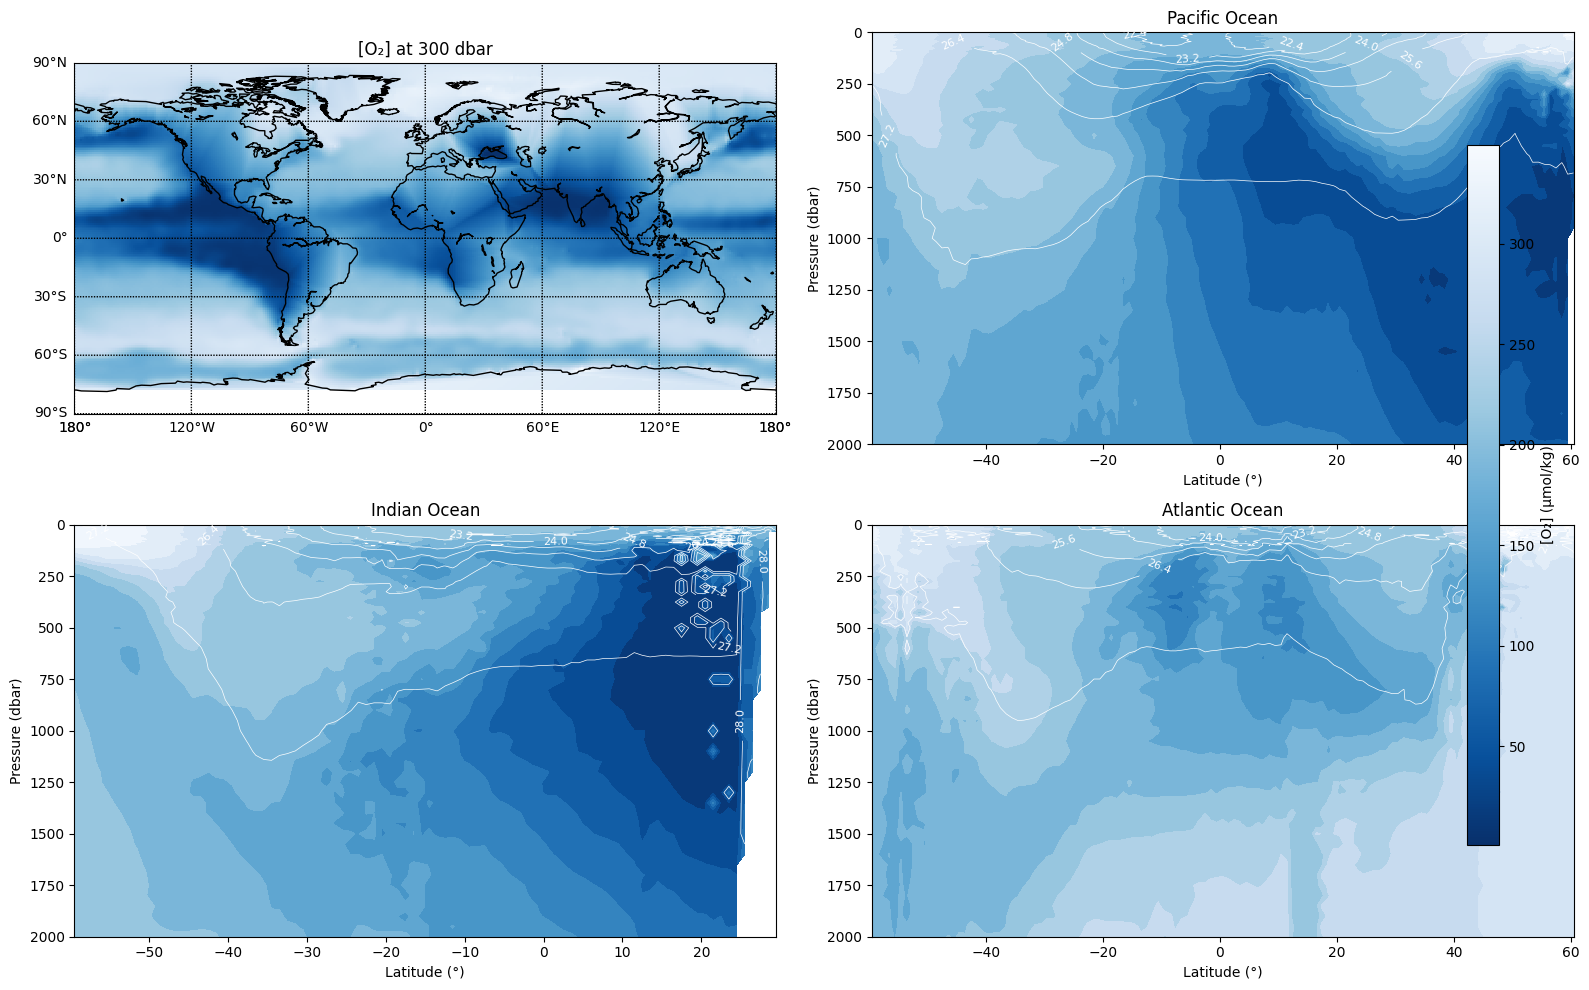

In [29]:
# Call the function to plot
plot_ocean_sections(map_data, pacific_data, indian_data, atlantic_data)
